# Myers Briggs Personality Type Classification - Full

### Carolina Analytics and Data Science

Data from [Kaggle](https://www.kaggle.com/datasnaek/mbti-type)

The goal for this dataset will to be able to classify Myers Briggs Personality Type (MBTI) based on text someone with that personality type had written. In our meeting on Febuary 15 we will choose which 

This is starter code to get working on this dataset.

Note there are two versions of this document. In this (the "full") we go from a sample of the messy text dataset available on Kaggle, featurize, build our models, and predict. In the other document we start with already featurized text that we have made here so that jumping right into the modelling is also an option. 

In [1]:
import tensorflow as tf # neural net library
import numpy as np      # numerical/linear algebra
import pandas as pd     # reading in data
import re               # regular expression
import wordcloud
import csv

### Reading in the data

In [2]:
full_training_data = pd.read_csv('data/train.csv')
full_training_data = full_training_data.assign(ie=full_training_data['type'].str[0], 
                                               sn=full_training_data['type'].str[1],
                                               tf=full_training_data['type'].str[2],
                                               pj=full_training_data['type'].str[3],
                                              ) # separating each of the potential types to predict

testing_data = pd.read_csv('data/test.csv')

full_training_data

,instance,type,posts,ie,sn,tf,pj
0,3629,INFJ,ok by me :happy: It will give me time to orga...,I,N,F,J
1,4105,ISTJ,'ask him straight up|||kiss- isxp marry- isfp ...,I,S,T,J
2,7127,ENTJ,'Thank you!|||This exactly. I think my SO is a...,E,N,T,J
3,358,INTP,'Never mind.|||Your brain doesn't ever change ...,I,N,T,P
4,1082,ENTP,I always thought you had an abundance of Ne.||...,E,N,T,P
5,59,INTJ,I feel some way about people that can't solve ...,I,N,T,J
6,4375,INTJ,"'It was too easy when I was younger, so I stop...",I,N,T,J
7,4777,INTJ,'The series' audience is kids in their school ...,I,N,T,J
8,5078,INFJ,'The best relationship to be in is one where b...,I,N,F,J
9,87,ISFJ,'i beat that by seeking out a housemate that w...,I,S,F,J


We observe the format of the data is (instance, type, posts) and we have added more columns which split up type.


### Initial Cleanup 
- Removes non-alpha characters
- Splitting text into individual words

We do this for both the testing and training data.


#### *Area to improve* 
- Change what is being removed. Maybe remove hyperlinks, lemmatize or stem the text. 
- Split into [bigrams](https://en.wikipedia.org/wiki/Bigram)

In [3]:
full_training_data['clean_text'] = full_training_data['posts'].apply(lambda x: re.sub('[^a-z]+', ' ', x.lower()))

full_training_data_words = pd.DataFrame(full_training_data.clean_text.str.split(' ').tolist(), 
                                  full_training_data.instance
                                 ).stack() # splits into words

full_training_data_words = full_training_data_words.reset_index()[[0, 'instance']]
full_training_data_words.columns = ['word', 'instance']
full_training_data_words = full_training_data_words[full_training_data_words.word != ""]

full_training_data_words = full_training_data[["instance", "ie", "sn", "tf", "pj"]].set_index('instance').join(
                                            full_training_data_words.set_index('instance')
                                            ).reset_index()



testing_data['clean_text'] = testing_data['posts'].apply(
    lambda x: re.sub('[^a-z]+', ' ', x.lower())
)

testing_data = pd.DataFrame(testing_data.clean_text.str.split(' ').tolist(), 
                            testing_data.instance).stack()
testing_data_words = testing_data.reset_index()[[0, 'instance']]
testing_data_words.columns = ['word', 'instance']

full_training_data_words

,instance,ie,sn,tf,pj,word
0,0,I,N,F,J,http
1,0,I,N,F,J,www
2,0,I,N,F,J,youtube
3,0,I,N,F,J,com
4,0,I,N,F,J,watch
5,0,I,N,F,J,v
6,0,I,N,F,J,qsxhcwe
7,0,I,N,F,J,krw
8,0,I,N,F,J,http
9,0,I,N,F,J,media


We now can query for specific words and do some analysis on the vocabulary.

### (very brief) Exploratory Data Analysis

We will make 8 word clouds for each of the personality categorizations (meaning I, E, N, S, T, F, J, and P)

#### *Area to improve* 
We did virtually no exploratory data analysis. This is one of the simpler parts and can give you a lot of insight prior to modelling of trends that are occuring. 

## Full Dataset Word Cloud

(-0.5, 399.5, 199.5, -0.5)

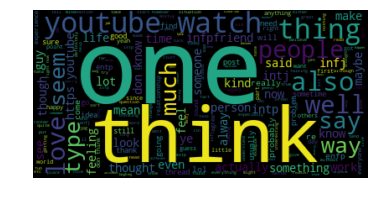

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
cloud = wordcloud.WordCloud().generate(" ".join(full_training_data_words["word"]))

plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")

## All of the categorizations

(-0.5, 399.5, 199.5, -0.5)

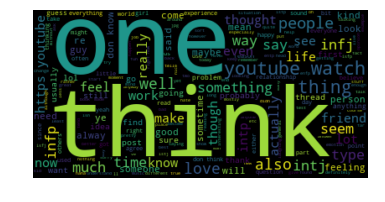

In [5]:
introvert_cloud = wordcloud.WordCloud().generate(
    " ".join(full_training_data_words.loc[full_training_data_words.ie == "I"]["word"])
)

plt.imshow(introvert_cloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

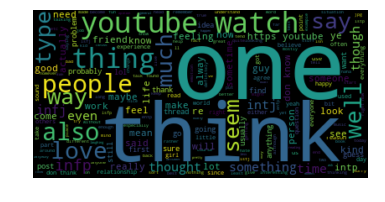

In [6]:
extravert_cloud = wordcloud.WordCloud().generate(
    " ".join(full_training_data_words.loc[full_training_data_words.ie == "I"]["word"])
)

plt.imshow(extravert_cloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

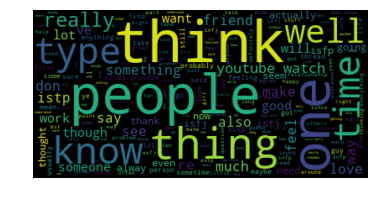

In [7]:
sensing_cloud = wordcloud.WordCloud().generate(
    " ".join(full_training_data_words.loc[full_training_data_words.sn == "S"]["word"])
)

plt.imshow(sensing_cloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

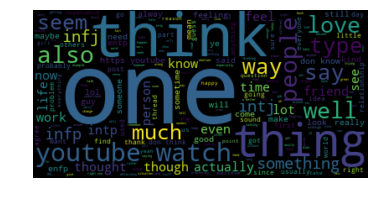

In [8]:
intuitive_cloud = wordcloud.WordCloud().generate(
    " ".join(full_training_data_words.loc[full_training_data_words.sn == "N"]["word"])
)

plt.imshow(intuitive_cloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

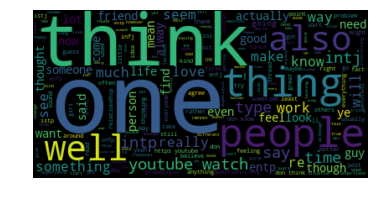

In [9]:
thinking_cloud = wordcloud.WordCloud().generate(
    " ".join(full_training_data_words.loc[full_training_data_words.tf == "T"]["word"])
)

plt.imshow(thinking_cloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

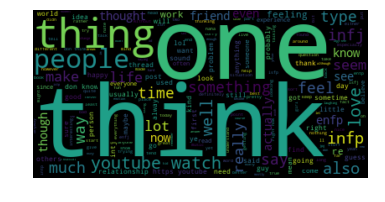

In [10]:
feeling_cloud = wordcloud.WordCloud().generate(
    " ".join(full_training_data_words.loc[full_training_data_words.tf == "F"]["word"])
)

plt.imshow(feeling_cloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

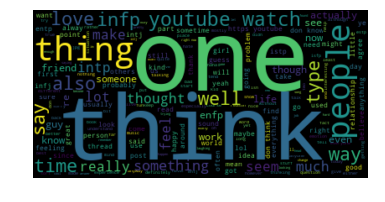

In [11]:
percieving_cloud = wordcloud.WordCloud().generate(
    " ".join(full_training_data_words.loc[full_training_data_words.pj == "P"]["word"])
)

plt.imshow(percieving_cloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

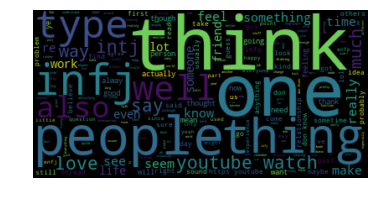

In [12]:
judging_cloud = wordcloud.WordCloud().generate(
    " ".join(full_training_data_words.loc[full_training_data_words.pj == "J"]["word"])
)

plt.imshow(judging_cloud, interpolation='bilinear')
plt.axis("off")

## Featurization

We can see that each of the type binaries has differences, but we need a way to turn those text differences into something numerical.

There are many, many ways to do this, and the one we have done is somewhat homemade.

### Our Process
1. [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)
    - way to rank the important words in each document
    - Get the top n words for each instance
    - Idea is that those top n words most uniquely distinguish this document from other documents
    
2. [GloVe](https://nlp.stanford.edu/projects/glove/) 
    - Word embeddings or vectorized representation of words
    - Sum the word embeddings for the top n words found in step 1 for each instance.
    
#### TF-IDF

For tf idf going to use 

$$(1+log(tf))log(N/df)$$ 

tf is count of a single term in an instance, N is the total number of instances and df is the total number of documents that that term appears in.

##### *Area for improvement*
Experiment with different tf-idf calculations.

##### TF step 
get the total occurances of each word in each instance

In [13]:
full_training_data_words['term_frequency'] = 0
training_data_tf = full_training_data_words[
                        ['instance', 'word', 'term_frequency']
                    ].groupby(['instance', 'word']).agg("count")

testing_data_words['term_frequency'] = 0
testing_data_tf = testing_data_words[
                        ['instance', 'word', 'term_frequency']
                    ].groupby(['instance', 'word']).agg("count") 

training_data_tf

term_frequency
instance word                       
0        a                        17
         about                     2
         again                     1
         ages                      1
         ago                       1
         ahh                       1
         all                       4
         alternative               1
         always                    1
         am                        1
         an                        3
         and                      13
         any                       1
         apis                      1
         appears                   1
         aq                        1
         are                       2
         area                      1
         around                    1
         artist                    1
         artists                   2
         as                        4
         assets                    1
         at                        3
         aug                       1
         avid                      1
         b                         4
         baby                      1
         backyard                  2
         banned                    7
...                              ...
8674     when                      6
         whenever                  1
         where                     1
         while                     2
         white                     3
         who                       6
         wilderness                1
         will                      5
         window                    2
         wipes                     1
         with                     11
         without                   1
         wolf                      2
         won                       3
         work                      3
         worker                    1
         world                     5
         would                     5
         wouldn                    1
         wrong                     2
         www                       3
         xd                        1
         yea                       1
         yes                       2
         you                      15
         young                     1
         your                      8
         yours                     1
         yourself                  2
         youtube                   3

[3651859 rows x 1 columns]

##### IDF Step

Here we are using and IDF table just from the training set.

We also drop words that don't appear in at least 10 documents, because they are likely too specific or are gibberish, and this greatly cuts down on comuptation time later.

*Area for improvement* - compute an IDF table from another source or including the test set, as this can cause some amount of overfitting with the training set.

In [14]:
document_frequency = training_data_tf.reset_index()[['instance','word']].set_index("word").groupby("word").agg("count")
document_frequency = document_frequency.loc[document_frequency['instance'] >= 10] # drop terms that exist in less that 10 documents
document_frequency

,instance
word,
a,6939
aa,96
aaaaaaaaa,18
aaaaand,12
aaaah,15
aaaand,17
aaah,19
aaand,13
aah,16


In [15]:
total_count = len(document_frequency)
document_frequency['idf'] = np.log(
                                float(total_count) / document_frequency['instance']
                            )
idf_table = document_frequency.reset_index()[['word', 'idf']]
idf_table.sort_values(by="idf")

,word,idf
0,a,0.956708
7737,i,0.956708
16288,to,0.956852
16058,the,0.956996
618,and,0.957285
11052,of,0.957429
8512,is,0.957573
8548,it,0.958006
17979,you,0.958150
7943,in,0.959161


##### Joining the two

In [16]:
training_tfidf = training_data_tf.reset_index().set_index('word').join(idf_table.set_index('word'), how='inner')
training_tfidf = training_tfidf.reset_index()
training_tfidf['tfidf'] = (1+np.log(training_tfidf['term_frequency']))*training_tfidf['idf']

testing_tfidf = testing_data_tf.reset_index().set_index('word').join(idf_table.set_index('word'), how='inner')
testing_tfidf = testing_tfidf.reset_index()
testing_tfidf['tfidf'] = (1+np.log(testing_tfidf['term_frequency']))*testing_tfidf['idf']

training_tfidf

,word,instance,term_frequency,idf,tfidf
0,a,0,17,0.956708,3.667266
1,a,1,26,0.956708,4.073755
2,a,3,23,0.956708,3.956460
3,a,5,37,0.956708,4.411302
4,a,6,39,0.956708,4.461667
5,a,7,26,0.956708,4.073755
6,a,8,27,0.956708,4.109861
7,a,9,26,0.956708,4.073755
8,a,10,44,0.956708,4.577072
9,a,12,29,0.956708,4.178227


#### Choosing the N largest
Sorting for each instance and choosing the N=10 largest tf-idf valued items.

##### *Area for improvement*
Vary the value of N. This could be too high or too low.

In [17]:
highest_training_tfidf = training_tfidf[['instance', 'word', 'tfidf']].set_index("word").groupby(['instance'])['tfidf'].nlargest(10).reset_index()

highest_testing_tfidf = testing_tfidf[['instance', 'word', 'tfidf']].set_index("word").groupby(['instance'])['tfidf'].nlargest(10).reset_index()


In [18]:
highest_training_tfidf

,instance,word,tfidf
0,0,banned,14.173329
1,0,dp,10.894259
2,0,pokemon,10.557985
3,0,backyard,10.436618
4,0,moderation,10.188397
5,0,diary,9.176171
6,0,cavemen,7.499036
7,0,artists,7.351705
8,0,happenings,7.316714
9,0,revel,7.316714


### Using GloVe

You must download this file separaetly from Github and unzip it into the folder of this notebook file. The download is [here](http://nlp.stanford.edu/data/glove.6B.zip)

#### *Area for improvement*
We only use the 50 dimensional word embeddings, while using more could potentially lead to better results. 

In [19]:
glove = pd.read_table('glove/glove.6B.50d.txt', 
                      sep=' ', 
                      index_col=0, 
                      header=None, 
                      quoting=csv.QUOTE_NONE)
glove

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
0,,,,,,,,,,,,,,,,,,,,,
the,0.418000,0.249680,-0.412420,0.121700,0.345270,-0.044457,-0.496880,-0.178620,-0.000660,-0.656600,...,-0.298710,-0.157490,-0.347580,-0.045637,-0.442510,0.187850,0.002785,-0.184110,-0.115140,-0.785810
",",0.013441,0.236820,-0.168990,0.409510,0.638120,0.477090,-0.428520,-0.556410,-0.364000,-0.239380,...,-0.080262,0.630030,0.321110,-0.467650,0.227860,0.360340,-0.378180,-0.566570,0.044691,0.303920
.,0.151640,0.301770,-0.167630,0.176840,0.317190,0.339730,-0.434780,-0.310860,-0.449990,-0.294860,...,-0.000064,0.068987,0.087939,-0.102850,-0.139310,0.223140,-0.080803,-0.356520,0.016413,0.102160
of,0.708530,0.570880,-0.471600,0.180480,0.544490,0.726030,0.181570,-0.523930,0.103810,-0.175660,...,-0.347270,0.284830,0.075693,-0.062178,-0.389880,0.229020,-0.216170,-0.225620,-0.093918,-0.803750
to,0.680470,-0.039263,0.301860,-0.177920,0.429620,0.032246,-0.413760,0.132280,-0.298470,-0.085253,...,-0.094375,0.018324,0.210480,-0.030880,-0.197220,0.082279,-0.094340,-0.073297,-0.064699,-0.260440
and,0.268180,0.143460,-0.278770,0.016257,0.113840,0.699230,-0.513320,-0.473680,-0.330750,-0.138340,...,-0.069043,0.368850,0.251680,-0.245170,0.253810,0.136700,-0.311780,-0.632100,-0.250280,-0.380970
in,0.330420,0.249950,-0.608740,0.109230,0.036372,0.151000,-0.550830,-0.074239,-0.092307,-0.328210,...,-0.486090,-0.008027,0.031184,-0.365760,-0.426990,0.421640,-0.116660,-0.507030,-0.027273,-0.532850
a,0.217050,0.465150,-0.467570,0.100820,1.013500,0.748450,-0.531040,-0.262560,0.168120,0.131820,...,0.138130,0.369730,-0.642890,0.024142,-0.039315,-0.260370,0.120170,-0.043782,0.410130,0.179600
"""",0.257690,0.456290,-0.769740,-0.376790,0.592720,-0.063527,0.205450,-0.573850,-0.290090,-0.136620,...,0.030498,-0.395430,-0.385150,-1.000200,0.087599,-0.310090,-0.346770,-0.314380,0.750040,0.970650


#### Area for improvement
Here we simply join with GloVe. There are potential issues here as words in our training set may not be in the words in GloVe, so some of the top n words we found may not have representations. Either taking more words, automatically removing words that aren't in GloVe, or joining in some smarter way could all potentially improve the featurization.

Additionally GloVe has vectorized punctuation, so not removing punctuation could help.

In [20]:
training_with_glove = highest_training_tfidf[['instance', 'word']].set_index('word').join(glove.reset_index().set_index(0), how='inner')
testing_with_glove = highest_testing_tfidf[['instance', 'word']].set_index('word').join(glove.reset_index().set_index(0), how='inner')

#### Summing the word embeddings
Here we sum word embeddings for each instance and then normalize so that each instance is a unit vector

##### Area for improvement
- use a weighted sum of terms. We are not using the TF-IDF information any more. Potentially weighting the embeddings with the tf-idf value could favor one semantic meaning. 

In [28]:
featurized_training = training_with_glove.reset_index().drop('index', axis=1).groupby('instance').sum()
training_magnitude = featurized_training[1]*0
for i in range(1, 51): # features of x
    training_magnitude += featurized_training[i]**2

for i in range(1, 51):
    featurized_training[i] = featurized_training[i] / training_magnitude # normalization

featurized_testing = testing_with_glove.reset_index().drop('index', axis=1).groupby('instance').sum()
testing_magnitude = featurized_testing[1]*0
for i in range(1, 51): # features of x
    testing_magnitude += featurized_testing[i]**2

for i in range(1, 51):
    featurized_testing[i] = featurized_testing[i] / testing_magnitude # normalization
    
featurized_training

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
instance,,,,,,,,,,,,,,,,,,,,,
0,0.000372,-0.001298,-0.010062,0.001355,-0.005022,-0.006287,-0.008383,-0.014052,-0.003321,0.010114,...,0.000825,-0.003857,-0.003016,0.016385,0.012746,0.000269,-0.000613,-0.002917,-0.003722,-0.001532
1,-0.006824,-0.006367,0.007478,0.014629,-0.005119,0.002251,-0.007300,-0.003362,0.004598,0.000668,...,0.006190,-0.002087,-0.009160,-0.001811,0.002467,-0.000759,0.004361,-0.007137,-0.004017,-0.005253
3,0.006406,0.000425,-0.013927,0.000148,-0.000447,0.000337,0.013514,-0.008110,-0.001856,0.015368,...,-0.009213,-0.003473,-0.005136,0.009033,-0.009436,-0.005015,0.011228,0.006944,-0.002455,0.004098
5,0.000211,-0.018337,-0.004811,-0.009200,0.006490,0.005712,0.001549,-0.004857,-0.008143,0.007790,...,0.002786,0.004478,0.002383,0.006946,0.003760,-0.009377,0.007509,0.002630,0.006239,0.002147
6,0.007253,0.011320,-0.000309,-0.005211,-0.005087,0.003551,0.005003,0.001285,0.000416,0.001116,...,0.003874,-0.009900,0.005984,0.002938,-0.000188,0.004671,0.012981,-0.000446,0.000618,0.003864
7,-0.000916,0.001911,0.002414,-0.010966,0.003653,-0.001730,0.002944,-0.000487,-0.002043,0.005744,...,0.001038,-0.002603,0.000982,0.014752,-0.012192,0.002602,0.013320,0.001145,-0.000839,-0.009248
8,0.009903,-0.006805,-0.005869,0.002846,0.004691,0.003766,0.006486,0.002056,0.011632,0.017744,...,0.007043,0.007308,-0.015438,0.010698,-0.004815,0.008983,0.004357,-0.000306,0.002203,0.004779
9,0.006662,0.001315,-0.002986,-0.006207,0.001163,0.002566,0.003559,-0.006805,0.002235,0.008130,...,0.001804,-0.001529,-0.000435,0.001685,0.003642,0.003647,0.002501,-0.003127,-0.000188,0.006028
10,0.003701,-0.001179,-0.003764,0.000056,0.011367,0.000579,-0.008022,0.000436,-0.000829,0.001616,...,-0.003731,-0.001446,-0.000469,0.007575,0.005279,-0.001729,-0.003099,-0.006604,0.004023,-0.002939


In [22]:
full_training_featurized = full_training_data.set_index('instance')[['ie', 'sn', 'tf', 'pj']].join(featurized_training)
full_training_featurized # joined back with labels

,ie,sn,tf,pj,1,2,3,4,5,6,...,41,42,43,44,45,46,47,48,49,50
instance,,,,,,,,,,,,,,,,,,,,,
3629,I,N,F,J,-0.007057,0.011834,-0.006989,-0.005588,0.001824,-0.003786,...,-0.000680,0.000563,-0.007457,-0.000792,-0.001238,0.001799,-0.003256,-0.004807,0.001807,0.006461
4105,I,S,T,J,-0.010595,-0.003893,-0.003998,-0.001171,0.000272,0.001339,...,-0.003302,-0.000975,0.004997,0.012581,-0.003539,-0.004653,-0.002117,0.009464,0.002484,0.015821
7127,E,N,T,J,0.006943,-0.004974,-0.002881,-0.000854,-0.008003,-0.003119,...,-0.010723,-0.000851,0.006810,0.001517,0.000906,0.003234,0.001323,0.007701,-0.000370,-0.000787
358,I,N,T,P,0.004971,0.002491,-0.001977,-0.010121,0.006501,0.001179,...,-0.001910,-0.005556,-0.002658,0.006724,0.002027,0.001406,0.002798,0.004720,-0.000559,-0.007140
1082,E,N,T,P,-0.005518,-0.013836,-0.000653,-0.022463,-0.008961,0.001532,...,0.003058,0.000124,0.000085,-0.001071,0.017762,-0.000640,0.010176,0.001667,0.012328,-0.006646
59,I,N,T,J,0.005496,-0.016923,0.002353,-0.003627,0.004239,0.003851,...,0.000374,-0.001072,-0.004279,0.009227,-0.001462,0.002938,-0.000676,0.004286,0.007045,0.003323
4375,I,N,T,J,-0.001455,0.000493,-0.003069,-0.007051,0.004451,0.000301,...,0.001886,-0.006067,-0.001422,0.012858,0.000376,0.001671,-0.003497,0.006543,-0.004860,-0.006801
4777,I,N,T,J,0.003416,-0.004457,0.002819,-0.002996,-0.000930,0.002626,...,0.004037,-0.011160,0.011770,0.009662,-0.004666,-0.002340,0.001461,0.016813,0.001325,-0.000458
5078,I,N,F,J,0.009547,-0.006512,0.001096,-0.004917,0.006475,0.002340,...,-0.003150,-0.004453,0.009139,0.009850,0.012124,-0.001870,-0.004001,-0.005334,-0.004746,-0.005077


Here is how we output these to csvs which is what is used for the abridged version.

In [30]:
full_training_featurized.to_csv('featurized_train.csv')
featurized_testing.to_csv('featurized_test.csv')

## Prediction

Splitting into test and validation sets

In [24]:
full_training_featurized['Y'] = (1*(full_training_featurized['ie'] == 'I')) # having a Y column that is 0-1 valued

np.random.seed(seed=1) # for consistency with test and training sets
training_data, validation_data = np.split(full_training_featurized.sample(frac=1), [int(.75*len(full_training_featurized))]) # splitting into training and validation sets

### Logistic Regression

In [31]:
training_x = training_data.drop(['ie', 'sn', 'tf', 'pj', 'Y'], axis=1)
training_y = training_data['Y']

validation_x = validation_data.drop(['ie', 'sn', 'tf', 'pj', 'Y'], axis=1)
validation_y = validation_data['Y']

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg = logreg.fit(training_x, training_y)

logreg.score(training_x, training_y) # training accuracy

0.7711815561959654

In [32]:
def evaluate_model(model, validation_x, validation_y): 
    # testing accuracy 
    correct = 0
    for (a, b) in zip(model.predict(validation_x), validation_y):
        correct += (a-b)**2
    return float(correct)/len(validation_y)

evaluate_model(logreg, validation_x, validation_y)

0.23804034582132566

### Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
random_forest = random_forest.fit(training_x, training_y)

random_forest.score(training_x, training_y) # training accuracy

0.99000960614793465

In [34]:
evaluate_model(random_forest, validation_x, validation_y) # testing accuracy 

0.2881844380403458

### Tensorflow Neural Net

In [35]:
tf_training_y = np.array([training_y, -(training_y-1)]).T
tf_validation_y = np.array([validation_y, -(validation_y-1)]).T
# Parameters
learning_rate = 0.001
training_epochs = 1000
batch_size = 100
display_step = 1


# Network Parameters
n_hidden_1 = 50 # 1st layer number of features
n_hidden_2 = 50 # 2nd layer number of features
n_input = 50 # Number of feature
n_classes = 2 # Number of classes to predict

# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = multilayer_perceptron(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

In [36]:
# Launch the graph

with tf.Session() as sess:
    sess.run(init)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(len(training_x)/batch_size)
        X_batches = np.array_split(training_x, total_batch)
        Y_batches = np.array_split(tf_training_y, total_batch)
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = X_batches[i], Y_batches[i]
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
                                                          y: batch_y})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))
    print("Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Testing Accuracy:", accuracy.eval({x: validation_x, y: tf_validation_y}))
    global result 
    result = tf.argmax(pred, 1).eval({x: validation_x, y: tf_validation_y})

Epoch: 0001 cost= 5.000520567
Epoch: 0002 cost= 0.663520690
Epoch: 0003 cost= 0.623145800
Epoch: 0004 cost= 0.610185574
Epoch: 0005 cost= 0.598423030
Epoch: 0006 cost= 0.588041391
Epoch: 0007 cost= 0.579052913
Epoch: 0008 cost= 0.571371927
Epoch: 0009 cost= 0.564798927
Epoch: 0010 cost= 0.559198960
Epoch: 0011 cost= 0.554438068
Epoch: 0012 cost= 0.550394094
Epoch: 0013 cost= 0.546957934
Epoch: 0014 cost= 0.544026554
Epoch: 0015 cost= 0.541522578
Epoch: 0016 cost= 0.539363967
Epoch: 0017 cost= 0.537503025
Epoch: 0018 cost= 0.535893123
Epoch: 0019 cost= 0.534499593
Epoch: 0020 cost= 0.533290865
Epoch: 0021 cost= 0.532244203
Epoch: 0022 cost= 0.531347807
Epoch: 0023 cost= 0.530580774
Epoch: 0024 cost= 0.529925157
Epoch: 0025 cost= 0.529370949
Epoch: 0026 cost= 0.528912959
Epoch: 0027 cost= 0.528534929
Epoch: 0028 cost= 0.528244441
Epoch: 0029 cost= 0.527992622
Epoch: 0030 cost= 0.527793967
Epoch: 0031 cost= 0.527650331
Epoch: 0032 cost= 0.527541108
Epoch: 0033 cost= 0.527448621
Epoch: 003